# Assignment 2

Продемонстрировать положение No Free Lunch Theorem. (см материалы семинара)   
Качество работы оценивается по accuracy на тестовой выборке согласно пайплайну (см материалы семинара). Метод валидации (если вы его применяете) 5-fold cv.  
В выводе для каждой модели указать какие предположения она делает относительно данных. В выводе указать почему модель плохо / хорошо работает на сгенерированной вами выборке. Использовать пространство признаков размерности 2 при классификации и размерности 1 при регрессии. При возможности, нарисовать выборку на графике (цветами обозначить классы).  


1. Сгенерировать датасет для задачи бинарной классификации (binary crossentropy), 
на котором метод ближайших соседей работает хуже, чем логистическая регрессия. 

2. Сгенерировать датасет для задачи бинарной классификации (binary crossentropy), 
на котором логистическая регрессия работает хуже, чем метод ближайших соседей.

3. Сгенерировать датасет для задачи бинарной классификации (binary crossentropy), 
на котором метод ближайших соседей с косинусной метрикой расстояния работает лучше, чем с евклидовой метрикой.

4. Сгенерировать датасет для задачи регрессии (MSE),
на котором решающее дерево работает хуже, чем линейная регрессия. 


In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame

from sklearn.datasets import make_regression
from sklearn.datasets import make_circles

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

In [3]:
def pipeline(X, y, c1, c2, y_p, y2_p, yf1, yf2):
    clf1 = c1
    clf2 = c2
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23)
    y_p.append(cross_val_score(clf1, X, y, cv=5, scoring='accuracy').mean())
    y2_p.append(cross_val_score(clf2, X, y, cv=5, scoring='accuracy').mean())
    clf1.fit(X_train, y_train)
    r1 = clf1.predict(X_test)
    yf1.append(accuracy_score(r1, y_test))
    clf2.fit(X_train, y_train)
    r2 = clf2.predict(X_test)
    yf2.append(accuracy_score(r2, y_test))
    return y_p, y2_p, yf1, yf2

## 1 KNN < LogisticRegression

Если есть линейно разделимая выборка на двух близких прямых, то ближе могут быть другой класс, а не свой. В таком случае KNN работает хуже, так как много соседей, относящихся к другому классу, хотя выборка линейно разделима, с чем отлично справляется логистическая регрессия.

In [4]:
def generate_lines(n):
    X = []
    y = []
    X.extend([[x, np.tan(np.pi/4)*x] for x in np.linspace(1,1000, n)])
    X.extend([[x, np.tan(np.pi/4+0.1/n)*x] for x in np.linspace(1,1000, n)])
    y.extend([1]*n)
    y.extend([0]*n)
    return X, y

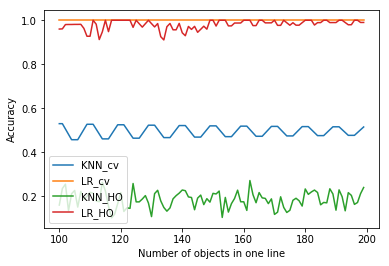

In [5]:
x_p, y_p, y2_p, yf1, yf2 = [],[],[],[],[]
for i in range (100, 200, 1):
    X, y = generate_lines(i)
    clf1 = KNeighborsClassifier()
    clf2 = LogisticRegression(solver='liblinear')
    y_p, y2_p, yf1, yf2 = pipeline(X, y, clf1, clf2, y_p, y2_p, yf1, yf2)
    x_p.append(i)
plt.plot(x_p, y_p, x_p, y2_p, x_p, yf1, x_p, yf2)
plt.legend(['KNN_cv', 'LR_cv', 'KNN_HO','LR_HO'])
plt.xlabel('Number of objects in one line')
plt.ylabel('Accuracy')
plt.show()

Алгоритмы показывают существенную разницу, так как из-за близкого расположения, метод ближайших соседей принимает неверные решения, особенно на холдауте. В то же время логистическая регрессия очень хорошо справляется и качество не снижается на холдауте по сравнению с кросс-валидацией.

## 2 LogisticRegression < KNN



Метод ближайших соседей лучше работает, когда есть "сгустки" объектов класса, они сильно сгруппированы. Например, в центре группа точек одного класса,а вокруг - другой класс. Например, как на изображении ниже.

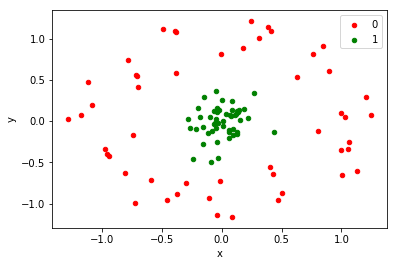

In [6]:
X, y = make_circles(n_samples=100, noise=0.15, factor=0.1)
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'green'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

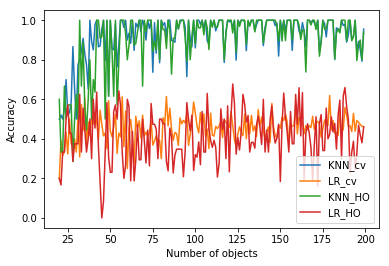

In [7]:
x_p, y_p, y2_p, yf1, yf2 = [],[],[],[],[]
for i in range (20, 200, 1):
    X, y = make_circles(n_samples=i, noise=random.uniform(0, 0.3), factor=random.uniform(0.1, 0.5))
    clf1 = KNeighborsClassifier()
    clf2 = LogisticRegression(solver='liblinear')
    y_p, y2_p, yf1, yf2 = pipeline(X, y, clf1, clf2, y_p, y2_p, yf1, yf2)
    x_p.append(i)
plt.plot(x_p, y_p, x_p, y2_p, x_p, yf1, x_p, yf2)
plt.legend(['KNN_cv', 'LR_cv', 'KNN_HO','LR_HO'])
plt.xlabel('Number of objects')
plt.ylabel('Accuracy')
plt.show()

При разном расстоянии между кольцами и уровне шума превосходство KNN сохрянаяется. Регрессия работает на уровне случайного выбора.

## 3  KNN cosine > KNN euclidean

Косинусная близость применяется тогда, когда вектора не нормализованы и имеют разную длину. Можно также привести и случай, когда точки расположены на одной прямой и точки на одной прямой относятся к одному классу, а на соседней, но под другим углом - другого. При близком расстоянии важнее нахождение на линии, чем соседство, что сразу снижает эффективность эвклидовой метрики.

In [8]:
def generate_ce(n):
    X = []
    y = []
    X.extend([[i, i*np.tan(np.pi/3.599)] for i in range(n)])
    X.extend([[i, i*np.tan(np.pi/3.6)] for i in range(n)])
    X.extend([[i, i*np.tan(np.pi/3.601)] for i in range(n)])
    y.extend([1]*n)
    y.extend([0]*n)
    y.extend([1]*n)
    return X, y

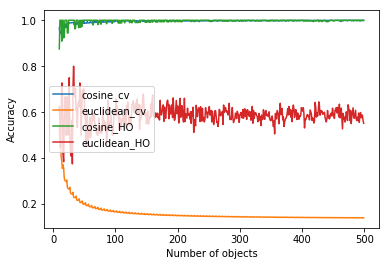

In [9]:
x_p, y_p, y2_p, yf1, yf2 = [],[],[],[],[]
for i in range (10, 500, 1):
    X, y = generate_ce(i)
    clf1 = KNeighborsClassifier(metric='cosine')
    clf2 = KNeighborsClassifier(metric='euclidean')
    y_p, y2_p, yf1, yf2 = pipeline(X, y, clf1, clf2, y_p, y2_p, yf1, yf2)
    x_p.append(i)
plt.plot(x_p, y_p, x_p, y2_p, x_p, yf1, x_p, yf2)
plt.legend(['cosine_cv', 'euclidean_cv', 'cosine_HO','euclidean_HO'])
plt.xlabel('Number of objects')
plt.ylabel('Accuracy')
plt.show()

## 4 MSE. Tree < Linear Regression

Дерево строится "ступенчато", а регрессия подбирает коэффициенты у прямой. Если объекты будут находиться строго по одной линии под наклоном, то дерево хуже приблизится, так как ступеньки не учтут возможные точки на прямой вне существующих и там будет накапливаться ошибка, тогда как при линейной регрессии они будут на прямой или близки к ней (небольшой разброс если есть).

In [10]:
def generate_reg(n):
    k = random.randint(1, 30)
    X = [[i] for i in (np.linspace(1, 100, n))]
    y = [k*i[0] + random.uniform(-0.1,0.1) for i in X]
    return np.array(X), np.array(y)

Немного изменим пайплайн с учетом других метрик

In [11]:
def pipeline(X, y, clf1, clf2, y_p, y2_p, yf1, yf2):
    X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=23)
    y_p.append(cross_val_score(clf1, X, y, cv=5, scoring='neg_mean_squared_error').mean())
    y2_p.append(cross_val_score(clf2, X, y, cv=5, scoring='neg_mean_squared_error').mean())
    clf1.fit(X_train, y_train)
    r1 = clf1.predict(X_test)
    yf1.append(mean_squared_error(r1, y_test))
    clf2.fit(X_train, y_train)
    r2 = clf2.predict(X_test)
    yf2.append(mean_squared_error(r2, y_test))
    return y_p, y2_p, yf1, yf2

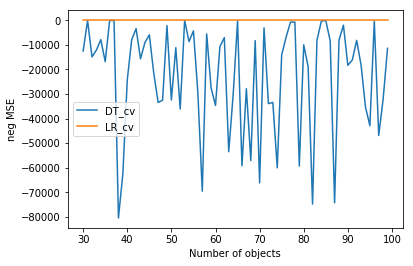

In [12]:
x_p, y_p, y2_p, yf1, yf2 = [],[],[],[],[]
for i in range (30, 100, 1):
    X, y = generate_reg(i)
    clf1 = DecisionTreeRegressor(criterion='mse')
    clf2 = LinearRegression()
    y_p, y2_p, yf1, yf2 = pipeline(X, y, clf1, clf2, y_p, y2_p, yf1, yf2)
    x_p.append(i)
plt.plot(x_p, y_p, x_p, y2_p)
plt.legend(['DT_cv', 'LR_cv', 'DT_ho','LR_ho'])
plt.xlabel('Number of objects')
plt.ylabel('neg MSE')
plt.show()

Очень большая ошибка на кросс-валидации.

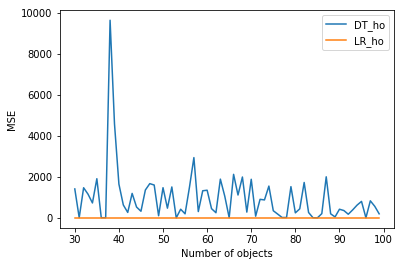

In [13]:
plt.plot(x_p, yf1, x_p, yf2)
plt.legend(['DT_ho','LR_ho'])
plt.xlabel('Number of objects')
plt.ylabel('MSE')
plt.show()

Постепенно с увеличение плотности точек средняя ошибка сокращается, однако при разреженном расположении на холдауте очень большая ошибка.